# Customer Analytics Capstone
### Edwin Ramirez

### Table of Contents
#### [Dataset 1: Marketing Campaign Effetiveness](#section1)
-  [Exploratory Data Analysis](#eda1)
-  [Multiple Linear Regression](#regression)
    -  [Feature Engineering](#feat-eng1)
    -  [Solution to Bimodal Distribution](#bimodal)
    -  [Model 1: MLR for Stores with Less Than 70k in Sales](#model1)
        -  [One Hot Encoding](#ohe1)
        -  [Feature Selection: Lasso Regression](#Lasso1)
        -  [Model Results](#results1)
    -  [Model 2: MLR For Stores with More Than 70k in Sales](#model2)
        - [Feature Selection: Lasso Regression](#lasso2)
        -  [K-Fold Cros Validation](#kfold)
-  [Random Forest](#random-forest)
    -  [Model 1: On Sales Less than 70 Thousand](#rf1)
    -  [Model 2: On Sales Greater than 70 Thousand](#rf2)
-  [Logistic Regression: Classifying Stores Below/Above 70k in Sales](#log1)
    -  [Feature Selection: Lasso Regression](#log3)
    -  [One Hot Encoding](#ohe2)
    -  [Feature Selection: Lasso Regression](#lasso3)
    -  [Model Results](#results3)
-  [Logistic Regression: Classifying Positive/Negative Profit for the Week](#log2)
    -  [Feature Selection: Lasso Regression](#lasso4)
    -  [Model Results](#results4)
    
-  [Model Summaries](#summary1)
    
    
#### [Dataset 2: Customer Churn Analysis](#churn)
-  [Data Preprocessing](#preprocessing)
-  [Logistic Regression: Classifying Churn Outcome](#log3)
    -  [One Hot Encoding](#ohe3)
    -  [Feature Engineering: Lasso Regression](#lasso5)
    -  [Model Results](#results5)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot as qq
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold
from yellowbrick.regressor import ResidualsPlot


# <a id = 'section1'> Dataset 1: Marketing Campaign Effectiveness </a>

At first glance into the data we can see that we have 548 rows of data data, and 7 features

In [2]:
df = pd.read_csv("Marketing_Campaign_Effectiveness.csv")
df.shape

(548, 7)

Further examination of the view of the data reveals that there are six categorical features, and one continuous. Before designing a model around this dataset further data exploration is required.

In [3]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands
0,1,Medium,1,4,3,1,33.73
1,1,Medium,1,4,3,2,35.67
2,1,Medium,1,4,3,3,29.03
3,1,Medium,1,4,3,4,39.25
4,1,Medium,2,5,2,1,27.81


## <a id = 'eda1'> Exploratory Data Analysis </a>

One of the first features that comes to mind to analyze would be the LocationID in order to determine the number of stores. Thus, we can determine the numbe of unique store IDs.

In [4]:
print("Number of Unique Stores: ", len(np.unique(df.LocationID)))

Number of Unique Stores:  137


However, we see that there are repeating values for these store IDs, and at first it appears that each location containins four rows of data each pertaining to weeks 1-4. However, just to confirm this, we take the value counts of all unique store IDs, and verify that all contain counts of 4. Therefore, the sum of this total should be equal to the unique number of stores.

In [5]:
store_counts = df.LocationID.value_counts()
print(store_counts[0:5])

verify_store_counts = [True if i == 4 else False for i in store_counts]
print("Total Stores: ", sum(verify_store_counts))

920    4
302    4
308    4
307    4
306    4
Name: LocationID, dtype: int64
Total Stores:  137


Potential models that could be designed include a Random Forest, Multiple Linear Regression, or a classification model using Logistic Regression. It all depends on what the outcome is that we're trying to predict. A first step would be to analyze the distribution of the desired outcome variable. A good place to start would be analyzing the one continuous feature in the dataset: **SalesInThousands**. This feature could be used as the outcome variables in a regression model if it meets the requirements of linearity:

- There must be a linear relationship between the outcome and predictor variables
- Normality indicates that the residuals are normally distributed
- The independent variables must be independent of one another
- The variance of error terms are similar across the values of the independent variables

A noticable aspect of this dataset is that **SalesInThousands** has a bimodal distribution, which signifies that there are two identifiable groups among this data. Unfortunately, using the raw dataset would break assumption of normality because we have two peaks in our distribution. Thus, a solution must be made in order to create a regression model.

C:\Users\edalr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


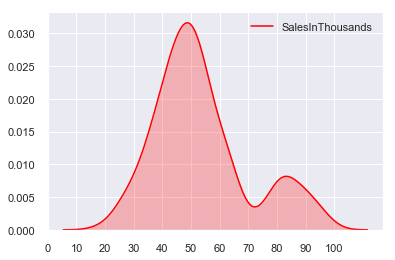

In [6]:
sns.set(color_codes=True)
ax = sns.kdeplot(df.SalesInThousands, shade = True, color = 'red')
plt.xticks([0,10,20,30,40,50,60,70,80,90,100])
plt.show()

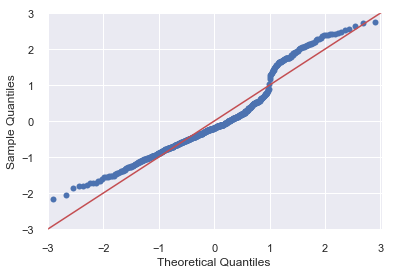

In [7]:
fig = qq(df.SalesInThousands, fit=True, line='45')
plt.show()

Additionally, we can see that there exists three types of market sizes in the data, where majority of the stores are classified under a medium market size. 

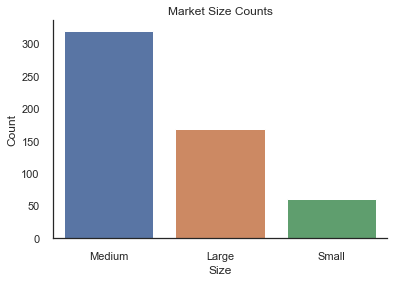

In [8]:
sns.set(style="white")
ax = sns.barplot(x=["Medium", "Large", "Small"], y=df.MarketSize.value_counts())
ax.set_title("Market Size Counts")
ax.set(ylabel = "Count", xlabel="Size")
sns.despine()
plt.show()

The distribution of the types of sales promotions at stores is almost evenly distributed amongst all locations. 

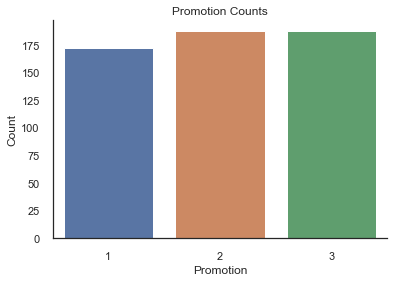

In [9]:
sns.set(style="white")
ax = sns.barplot(x=df.Promotion.value_counts().index, y=df.Promotion.value_counts())
ax.set_title("Promotion Counts")
ax.set(ylabel = "Count", xlabel="Promotion")
sns.despine()
plt.show()

The type of MarketID potentially indicates what sector or type of store a location is. As the data clearly shows, the most abundant stores are those that are of Market type 3 and 10.

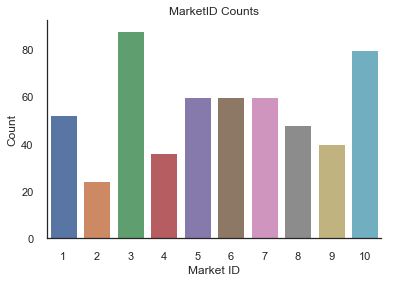

In [10]:
sns.set(style="white")
ax = sns.barplot(x=df.MarketID.value_counts().index, y=df.MarketID.value_counts())
ax.set_title("MarketID Counts")
ax.set(ylabel = "Count", xlabel="Market ID")
sns.despine()
plt.show()

The bar plot and distribution plot below indicate that most locations are relatively new within 1-5 years.

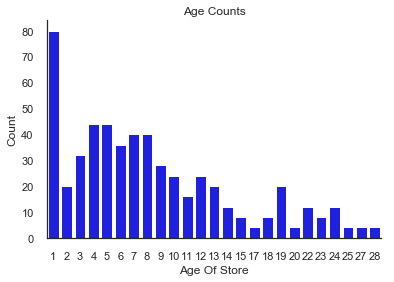

In [11]:
sns.set(style="white")
ax = sns.barplot(x=df.AgeOfStore.value_counts().index, y=df.AgeOfStore.value_counts(), color="blue")
ax.set_title("Age Counts")
ax.set(ylabel = "Count", xlabel="Age Of Store")
sns.despine()
plt.show()

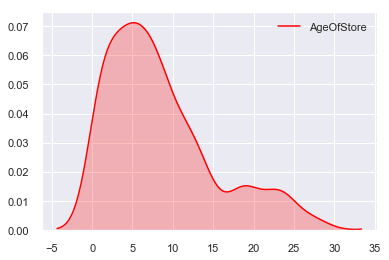

In [12]:
sns.set(color_codes=True)
ax = sns.kdeplot(df.AgeOfStore, shade = True, color = 'red')
plt.show()

## <a id = 'regression'> Multiple Linear Regression</a>

What is the utility in creating a multiple linear regression model out this data to predict sales? Ideally, the use of such a model could give insight on the potential sales for any of the promotions (in combination with any other selected features), and identify which promotion can generate more sales per location. 

### <a id = 'feat-eng1'> Feature Engineering </a>

#### Enumerate MarketSize

In [13]:
market_ = {i:j for j, i in enumerate(np.unique(df.MarketSize))}
market_
res = [market_[i] for i in df.MarketSize]
df['MarketSize'] = res

#### Percent Changes in Sales from Week to Week 

One unique aspect about the data is that it illustrates four separate weeks per store location, and the sales for that week. An additional feature can be engineered, where the percent change in sales from the previous week can be tracked, thus indicating a positive or negative percent change. 

In [14]:
no_locs = np.unique(df.LocationID)
pct_change = [list(df[df.LocationID == i].SalesInThousands.pct_change()) for i in no_locs]
pct_ch = [j for i in pct_change for j in i]

In [15]:
df['pct_change'] = pct_ch

In [16]:
df.fillna(0, inplace = True)
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,pct_change
0,1,1,1,4,3,1,33.73,0.000000
1,1,1,1,4,3,2,35.67,0.057516
2,1,1,1,4,3,3,29.03,-0.186151
3,1,1,1,4,3,4,39.25,0.352050
4,1,1,2,5,2,1,27.81,0.000000


### <a id = 'bimodal'> Solution to Bimodal Distribution </a>

We can split the data into the 2 groups and create models specifically for stores with Sales greater than and less than 73. We can arrive at the split at 73 because we can clearly see in the sales distribution that the local minimum is between peaks is between 70 and 75. The residual plots also follow the line assumptions in both cases, thus we can create two separate linear models. The first regression model will be for store locations that make less than 73k in sales, and the second will be for those that make more than 73k in sales.

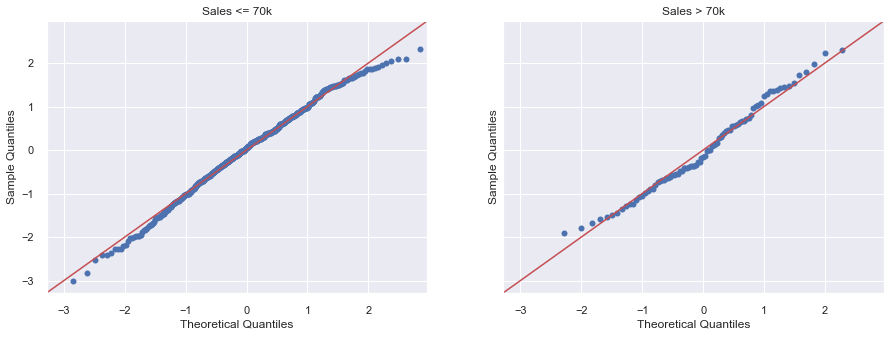

In [17]:
#Data with sales <= 73
sales_l70 = df[df.SalesInThousands <= 73].copy()
#Data with sales > 73
sales_g70 = df[df.SalesInThousands > 73].copy()


#Plot residuals for each set of data
sns.set(color_codes=True)
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
qq(sales_l70.SalesInThousands, fit=True, line='45', ax=ax[0])
qq(sales_g70.SalesInThousands, fit=True, line='45', ax=ax[1])
ax[0].set_title("Sales <= 70k")
ax[1].set_title("Sales > 70k")
plt.show()

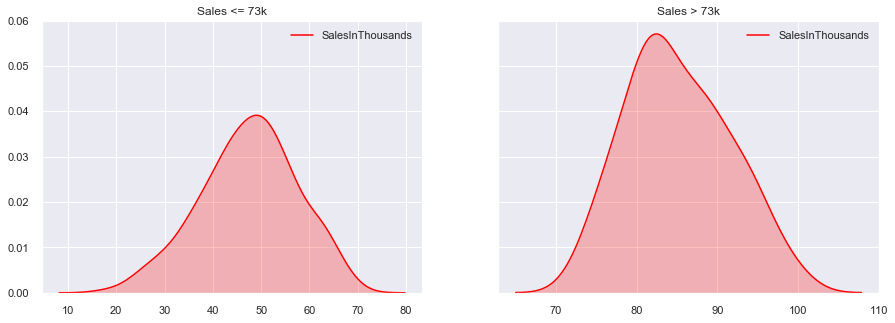

In [18]:
#Plot distributions for each set of data
sns.set(color_codes=True)
fig, ax = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15,5))
sns.kdeplot(sales_l70.SalesInThousands, shade = True, color = 'red', ax=ax[0])
sns.kdeplot(sales_g70.SalesInThousands, shade = True, color = 'red', ax=ax[1])
ax[0].set_title("Sales <= 73k")
ax[1].set_title("Sales > 73k")
plt.show()


In [19]:
#no. of stores with sales > 73
print("observations for stores with sales > 73k: ", sales_g70.shape[0])

observations for stores with sales > 73k:  87


In [20]:
#no. of stores with sales <= 73
print("observations for stores with sales <=73: ", sales_l70.shape[0])

observations for stores with sales <=73:  461


### <a id = 'model1'> Model 1: MLR for Stores with Less Than 70k in Sales </a>

In [21]:
#remove continuous variables
cols = list(df.drop(['SalesInThousands', 'AgeOfStore', 'pct_change', 'LocationID'], axis=1).columns)
cols

['MarketID', 'MarketSize', 'Promotion', 'week']

#### <a id = ohe1> One Hot Encode Relevant Categorical Variables in Both Datasets </a>

In [22]:
l70_df = pd.get_dummies(data=sales_l70, columns = cols, drop_first = True)

In [23]:
l70_df.head()

,LocationID,AgeOfStore,SalesInThousands,pct_change,MarketID_2,MarketID_3,MarketID_4,MarketID_5,MarketID_6,MarketID_7,MarketID_8,MarketID_9,MarketID_10,MarketSize_1,MarketSize_2,Promotion_2,Promotion_3,week_2,week_3,week_4
0,1,4,33.73,0.000000,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
1,1,4,35.67,0.057516,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0
2,1,4,29.03,-0.186151,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0
3,1,4,39.25,0.352050,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
4,2,5,27.81,0.000000,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0


In [24]:
l70_df.shape

(461, 20)

**Note: column sizes will differ in both datasets because `g70_df` has values from categorical features that only occur for stores that made sales more than 73 thousand**. One in particular that can be noted is the MarketID type, and MarketSize. MarketID type of the 3 is the only one seen in these observations, indicating that stores within this market are the ones that generate the most sales.

In [25]:
g70_df = pd.get_dummies(data=sales_g70, columns = cols, drop_first = True)

In [26]:
g70_df.head()

,LocationID,AgeOfStore,SalesInThousands,pct_change,Promotion_2,Promotion_3,week_2,week_3,week_4
76,201,4,86.14,0.000000,0,1,0,0,0
77,201,4,82.56,-0.041560,0,1,1,0,0
78,201,4,79.36,-0.038760,0,1,0,1,0
79,201,4,77.17,-0.027596,0,1,0,0,1
80,202,8,88.73,0.000000,0,0,0,0,0


Value counts of MarketID indicate that only ID 3 is the only one present in the data for this group

In [27]:
sales_g70.MarketID.value_counts()

3    87
Name: MarketID, dtype: int64

Value count of the MarketSize indicate that only large market sizes exist in this data group

In [28]:
sales_g70.MarketSize.value_counts()

0    87
Name: MarketSize, dtype: int64

In [29]:
g70_df.shape

(87, 9)

The first set of data contains for more observations that the dataset with stores that made greater than 70 thousand. Thus to get a better representation of model performance for this small sample size of data we will use K-Fold Cross validation when creating our model.

####  <a id = 'Lasso1'> Feature Selection: Lasso Regression </a>

Using Lasso regression, we can reduce the ceofficients of features that aren't useful as predictor variables to 0 and remove them from the overall model. LocationID can be dropped from the model to prevent having 137 one hot encoded store values. 

In [30]:
X_ = l70_df.drop(['SalesInThousands', 'LocationID'], axis = 1).copy()
y_ = l70_df.SalesInThousands.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 

#Feature Selection with Lasso Regression
clf = Lasso(alpha=0.1)
clf.fit(X=X_, y=y_)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [31]:
sel_feats = [True if np.abs(clf.coef_[i]) > 0 else False for i in range(len(clf.coef_)) ]
selected_feat = x_train.columns[(sel_feats)]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(sum(sel_feats)))
print('features with coefficients shrank to zero: {}'.format(len(sel_feats) - np.sum(sel_feats)))

total features: 18
selected features: 11
features with coefficients shrank to zero: 7


In [32]:
removed_feats = [i for i in x_train.columns if i not in selected_feat]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:
MarketID_3
MarketID_4
MarketID_10
MarketSize_2
week_2
week_3
week_4


In [33]:
print("features selected from Lasso Regression")
for i in selected_feat:
    print(i)

features selected from Lasso Regression
AgeOfStore
pct_change
MarketID_2
MarketID_5
MarketID_6
MarketID_7
MarketID_8
MarketID_9
MarketSize_1
Promotion_2
Promotion_3


####  <a id = 'results1'> Model Results </a>

We are left with 11 features in our model, which can be written as follows:

$\beta_{0} + \beta_{1}\text{AgeOfStore} + \beta_{2}\text{pct_change}... \beta_{11}\text{Promotion3} = \text{SalesInThousands}$

In [34]:
#remove unnecessary features from training
x_train_sel = x_train[selected_feat].copy()
x_test_sel = x_test[selected_feat].copy()

x_train_sel.shape,x_test_sel.shape

((368, 11), (93, 11))

In [35]:
lm = LinearRegression()
model = lm.fit(x_train_sel, y_train)

pred = lm.predict(x_test_sel)

lm1_mae = mean_absolute_error(y_test, pred)
print("Linear Model 1 MAE: %.3f" % lm1_mae)

r2_lm1 = round(r2_score(y_test, pred), 3)
print("R squared value", r2_lm1)

Linear Model 1 MAE: 3.004
R squared value 0.854


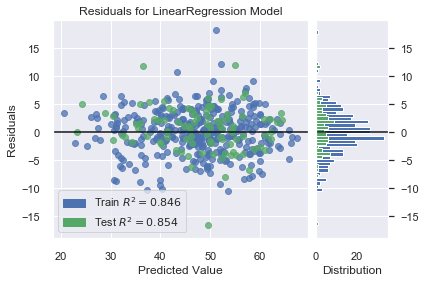

In [36]:
lm = LinearRegression()
visualizer = ResidualsPlot(lm)
visualizer.fit(x_train_sel, y_train)
visualizer.score(x_test_sel, y_test)
visualizer.show()

###  <a id = 'model2'> Model 2: MLR For Stores with More Than 70k in Sales </a>

#### <a id = "lasso2"> Feature Selection: Lasso Regression </a>

In [37]:
X_ = g70_df.drop(['SalesInThousands', 'LocationID'], axis = 1).copy()
X_.reset_index(drop = True, inplace=True)
y_ = g70_df.SalesInThousands.copy()
y_.reset_index(drop=True, inplace=True)

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 


#Feature Selection with Lasso Regression
clf = Lasso(alpha=0.1)
clf.fit(X=X_, y=y_)

sel_feats = [True if np.abs(clf.coef_[i]) > 0 else False for i in range(len(clf.coef_)) ]
selected_feat2 = x_train.columns[(sel_feats)]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(sum(sel_feats)))
print('features with coefficients shrank to zero: {}'.format(len(sel_feats) - np.sum(sel_feats)))

total features: 7
selected features: 7
features with coefficients shrank to zero: 0


In [38]:
removed_feats = [i for i in x_train.columns if i not in selected_feat2]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:


In [39]:
print("features selected from Lasso Regression")
for i in selected_feat2:
    print(i)

features selected from Lasso Regression
AgeOfStore
pct_change
Promotion_2
Promotion_3
week_2
week_3
week_4


In [40]:
#remove unnecessary features from training
x_train_sel = x_train[selected_feat2].copy()
x_test_sel = x_test[selected_feat2].copy()

x_train_sel.shape,x_test_sel.shape

((69, 7), (18, 7))

We are left with 7 features in our model, which can be written as follows:

$\beta_{0} + \beta_{1}\text{AgeOfStore} + \beta_{2}\text{pct_change}...+ \beta_{7}\text{week_4} = \text{SalesInThousands}$

In [41]:
lm = LinearRegression()
model = lm.fit(x_train_sel, y_train)

pred = lm.predict(x_test_sel)

lm2_mae = mean_absolute_error(y_test, pred)
print("Linear Model 2 MAE: %.3f" % lm1_mae)

r2_lm2 = round(r2_score(y_test, pred), 3)
print("R squared value", r2_lm2)

Linear Model 2 MAE: 3.004
R squared value 0.705


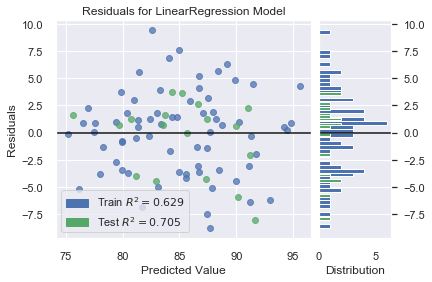

In [42]:
lm = LinearRegression()
visualizer = ResidualsPlot(lm)
visualizer.fit(x_train_sel, y_train)
visualizer.score(x_test_sel, y_test)
visualizer.show()

Using the data on its own at first may reveal a decent r squared value for this model, and looking at the residual plot may indicate that the errors themselves may be evenly distributed around zero. However, there isn't as much data available for this second model when compared to the first. Another approach would be to utilize K-Fold cross validation and see how the average performance is among the folds of data. 

####  <a id = 'kfold'> K-Fold Cros Validation </a>

In [43]:
#Remove unncessary features
cv = X_[selected_feat2].copy()

In [44]:
kf = KFold(n_splits = 4)
mae_vals = []
r2_vals = []
counter = 1
for train_index, test_index in kf.split(cv):
     
    x_train_k, x_test_k, y_train_k, y_test_k = cv.iloc[train_index, :], cv.iloc[test_index, :], y_.iloc[train_index], y_.iloc[test_index]
    
    lm = LinearRegression()
    model = lm.fit(x_train_k, y_train_k)
    pred = lm.predict(x_test_k)
    lm2_mae = mean_absolute_error(y_test_k, pred)
    mae_vals.append(lm2_mae)
    r2_vals.append(r2_score(y_test_k, pred))

In [45]:
m2_scores = [(i+1, mae_vals[i], r2_vals[i]) for i in range(len(r2_vals))]
m2_df = pd.DataFrame(m2_scores)
m2_df.columns= ['Fold Number', "MAE", "R2"]
m2_df

,Fold Number,MAE,R2
0,1,3.302872,0.327134
1,2,3.927317,0.347615
2,3,3.297952,0.555047
3,4,3.179785,0.665773


In [46]:
print("Model 2 Stats After K-Fold Cross Validation: ")
print("Avg R2: %.3f, Avg MAE: %.3f" % (m2_df.R2.mean(), m2_df.MAE.mean()))

Model 2 Stats After K-Fold Cross Validation: 
Avg R2: 0.474, Avg MAE: 3.427


The second regression model for stores that make greater than 70k in sales performs not great, but not too terribly. In terms of which one is better utilized for the second group, the k-fold cross validated model illustrates a more accurate representation of the model performance. 

##  <a id = 'random-forest'> Random Forest </a>

####  <a id = 'rf1'> Model 1: On Sales Less than 70 Thousand </a>

In [47]:
selected_feat

Index(['AgeOfStore', 'pct_change', 'MarketID_2', 'MarketID_5', 'MarketID_6',
       'MarketID_7', 'MarketID_8', 'MarketID_9', 'MarketSize_1', 'Promotion_2',
       'Promotion_3'],
      dtype='object')

In [48]:
len(selected_feat2)

7

We can use the previously selected features from Lasso Regression for both models

In [49]:
X_.head()

,AgeOfStore,pct_change,Promotion_2,Promotion_3,week_2,week_3,week_4
0,4,0.000000,0,1,0,0,0
1,4,-0.041560,0,1,1,0,0
2,4,-0.038760,0,1,0,1,0
3,4,-0.027596,0,1,0,0,1
4,8,0.000000,0,0,0,0,0


In [50]:
X_ = l70_df.drop(['SalesInThousands'], axis = 1).copy()
X_.reset_index(drop = True, inplace=True)
X_ = X_[selected_feat]
y_ = l70_df.SalesInThousands.copy()
y_.reset_index(drop = True, inplace=True)

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 

#Create base random forest model
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X=x_train,y=y_train)

pred = regr.predict(x_test)
l70_mae_rf = mean_absolute_error(y_test, pred)
l70_r2_rf = r2_score(y_test, pred)
print("Group 1 Random Forest MAE: %.3f" % l70_mae_rf)
print("Group 1 Random Forest R2: %.3f" % l70_r2_rf)

Group 1 Random Forest MAE: 5.763
Group 1 Random Forest R2: 0.515


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


####  <a id = 'rf2'>Model 2: On Sales Greater Than 70 Thousand </a>

In [51]:
X_ = g70_df.drop(['SalesInThousands'], axis = 1).copy()
X_.reset_index(drop = True, inplace=True)
X_ = X_[selected_feat2]
y_ = g70_df.SalesInThousands.copy()
y_.reset_index(drop = True, inplace=True)

#Split the data into test and training sets
x_train2, x_test2, y_train2, y_test2 = train_test_split(X_, y_, test_size=0.2, random_state=42) 

#Create base random forest model
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(X=x_train2,y=y_train2)

pred = regr.predict(x_test2)
g70_mae_rf = mean_absolute_error(y_test2, pred)
g70_r2_rf = r2_score(y_test2, pred)
print("Group 2 Random Forest MAE: %.3f" % g70_mae_rf)
print("Group 2 Random Forest R2: %.3f" % g70_r2_rf)

Group 2 Random Forest MAE: 4.270
Group 2 Random Forest R2: 0.294


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


## <a id = 'log1'>Logistic Regression: Classifying Stores Below/Above 70k in Sales</a>

In [52]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,pct_change
0,1,1,1,4,3,1,33.73,0.000000
1,1,1,1,4,3,2,35.67,0.057516
2,1,1,1,4,3,3,29.03,-0.186151
3,1,1,1,4,3,4,39.25,0.352050
4,1,1,2,5,2,1,27.81,0.000000


Make a threshold value to create a binary variable for stores that earn greater than 70k or less than.

In [53]:
sales70 = {True:1, False:0}
sales70_flag = [sales70[i > 70] for i in df.SalesInThousands]
df['sales70_flag'] = sales70_flag

In [54]:
df.head()

,MarketID,MarketSize,LocationID,AgeOfStore,Promotion,week,SalesInThousands,pct_change,sales70_flag
0,1,1,1,4,3,1,33.73,0.000000,0
1,1,1,1,4,3,2,35.67,0.057516,0
2,1,1,1,4,3,3,29.03,-0.186151,0
3,1,1,1,4,3,4,39.25,0.352050,0
4,1,1,2,5,2,1,27.81,0.000000,0


In [55]:
cols

['MarketID', 'MarketSize', 'Promotion', 'week']

In [56]:
log_df = pd.get_dummies(data=df, columns = cols, drop_first = True)
log_df.head()

,LocationID,AgeOfStore,SalesInThousands,pct_change,sales70_flag,MarketID_2,MarketID_3,MarketID_4,MarketID_5,MarketID_6,...,MarketID_8,MarketID_9,MarketID_10,MarketSize_1,MarketSize_2,Promotion_2,Promotion_3,week_2,week_3,week_4
0,1,4,33.73,0.000000,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
1,1,4,35.67,0.057516,0,0,0,0,0,0,...,0,0,0,1,0,0,1,1,0,0
2,1,4,29.03,-0.186151,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,1,0
3,1,4,39.25,0.352050,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,1
4,2,5,27.81,0.000000,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


### <a id = 'lasso3'>Feature Selection: Lasso Regression </a>

In [57]:
X_ = log_df.drop(['SalesInThousands', 'sales70_flag', 'LocationID'], axis = 1).copy()
y_ = log_df.sales70_flag.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 


#feature selection using Lasso
selected = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
selected.fit(x_train, y_train)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [58]:
selected_feat = x_train.columns[(selected.get_support())]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(selected.estimator_.coef_ == 0)))

total features: 18
selected features: 4
features with coefficients shrank to zero: 14


In [59]:
removed_feats = x_train.columns[(selected.estimator_.coef_ == 0).ravel().tolist()]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:
pct_change
MarketID_2
MarketID_4
MarketID_5
MarketID_6
MarketID_7
MarketID_8
MarketID_9
MarketSize_2
Promotion_2
Promotion_3
week_2
week_3
week_4


In [60]:
sel_feats = []
for i in x_train.columns:
    if(i not in removed_feats):
        sel_feats.append(i)
        
print("features selected from Lasso Regression:")
sel_feats

features selected from Lasso Regression:


['AgeOfStore', 'MarketID_3', 'MarketID_10', 'MarketSize_1']

In [61]:
#remove unnecessary features from training
x_train_sel = selected.transform(x_train.fillna(0))
x_test_sel = selected.transform(x_test.fillna(0))

x_train_sel.shape,x_test_sel.shape

((438, 4), (110, 4))

### <a id = 'results3'> Model Results</a>

In [62]:
lr = LogisticRegression(C=1, penalty='l1')
model = lr.fit(x_train_sel, y_train)
preds = lr.predict(x_test_sel)
print("Logistic Regression Accuracy: ", round(sum(preds == y_test)/len(y_test),3))

Logistic Regression Accuracy:  0.991


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


This high accuracy can be explained by the features selected when further analyzed. Specifically in **MarketSize**. The bimodal distribution of sales can ultimately be explained through the MarketSize of a store. Specifically, Large Market Sizes are the only subset of these stores that show bimodal distribution in their sales, where two peaks can be seen around 50 thousand and 85 thousand. Therefore, the classification model really only needs to know whether the market size of the store in order to properly classify it. Perhaps this dependent variables isn't the best in terms of classification, but there is one more that we can use. We can determine if a store will profit based on percent change and if it is positive or negative.

C:\Users\edalr\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


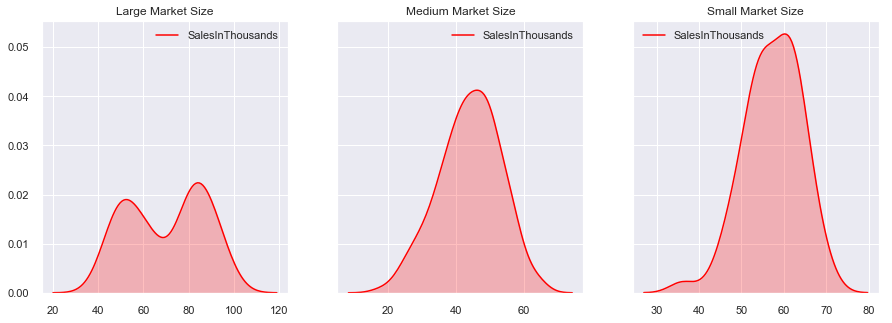

In [63]:
sns.set(color_codes=True)
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15,5))
sns.kdeplot(df[df.MarketSize == 0].SalesInThousands, shade = True, color = 'red', ax=ax[0])
sns.kdeplot(df[df.MarketSize == 1].SalesInThousands, shade = True, color = 'red', ax=ax[1])
sns.kdeplot(df[df.MarketSize == 2].SalesInThousands, shade = True, color = 'red', ax=ax[2])
ax[0].set_title("Large Market Size")
ax[1].set_title("Medium Market Size")
ax[2].set_title("Small Market Size")
plt.show()


## <a id = 'log2'> Logistic Regression: Classifying Positive/Negative Profit for the Week </a>

In [64]:
profit_ = {True:1, False:0}
profit_flag = [profit_[i > 0] for i in log_df['pct_change']]
log_df['profit_flag'] = profit_flag

In [65]:
df2 = log_df.drop(['pct_change', 'sales70_flag', 'LocationID'],axis=1).copy()
df2.head()

,AgeOfStore,SalesInThousands,MarketID_2,MarketID_3,MarketID_4,MarketID_5,MarketID_6,MarketID_7,MarketID_8,MarketID_9,MarketID_10,MarketSize_1,MarketSize_2,Promotion_2,Promotion_3,week_2,week_3,week_4,profit_flag
0,4,33.73,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0
1,4,35.67,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,1
2,4,29.03,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0
3,4,39.25,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,1
4,5,27.81,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0


### <a id = 'lasso4'> Feature Selection: Lasso Regression </a>

In [66]:
X_ = df2.drop(['profit_flag'], axis = 1).copy()
y_ = df2.profit_flag.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 


#feature selection using Lasso
selected = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
selected.fit(x_train, y_train)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [67]:
selected_feat = x_train.columns[(selected.get_support())]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(selected.estimator_.coef_ == 0)))

total features: 18
selected features: 16
features with coefficients shrank to zero: 2


In [68]:
removed_feats = x_train.columns[(selected.estimator_.coef_ == 0).ravel().tolist()]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:
MarketID_4
MarketSize_2


In [69]:
sel_feats = []
for i in x_train.columns:
    if(i not in removed_feats):
        sel_feats.append(i)
        
print("features selected from Lasso Regression:")
sel_feats

features selected from Lasso Regression:


['AgeOfStore',
 'SalesInThousands',
 'MarketID_2',
 'MarketID_3',
 'MarketID_5',
 'MarketID_6',
 'MarketID_7',
 'MarketID_8',
 'MarketID_9',
 'MarketID_10',
 'MarketSize_1',
 'Promotion_2',
 'Promotion_3',
 'week_2',
 'week_3',
 'week_4']

In [70]:
#remove unnecessary features from training
x_train_sel = selected.transform(x_train.fillna(0))
x_test_sel = selected.transform(x_test.fillna(0))

x_train_sel.shape,x_test_sel.shape

((438, 16), (110, 16))

### <a id = 'results4'> Model Results </a>

In [71]:
#Test Model
lr = LogisticRegression(C=1, penalty='l1')
model = lr.fit(x_train_sel, y_train)
preds = lr.predict(x_test_sel)
acc = round(sum(preds == y_test)/len(y_test),3)
print("Logistic Regression Accuracy with Profit as Dependent: ", acc)

Logistic Regression Accuracy with Profit as Dependent:  0.827


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## <a id = 'summary1'> Model Summaries </a>

In summary the best performing regression model would be the Multiple Linear Regression model created for group 1 for predicting the sales of stores that make less than 70k. The random forest models performed decently, and the best classification model is the logistic regression model for classifying a stores potential profit/loss for the given week. 

# <a id = 'churn'> Dataset 2: Customer Churn Dataset </a>

In [72]:
df2 = pd.read_csv("Customer_Churn_Dataset.csv")
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [73]:
df2.shape

(7043, 21)

## <a id = 'preprocessing'> Data Preprocessing </a>

In [74]:
cols2 = df2.columns
cols2

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [75]:
df2.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

The solution I used to determine which variables are categorical or continuous was to see if the unique values for each for variables was less than 10 values. The thought behind this is that all the unique values of a continuous features will give significantly more unique values than a categorical, with the exception of customer IDs, which will produce an ID for evert observation in the data. 

In [76]:
possible_categorical = [i  for i in cols2 if len(df2[i].value_counts()) < 11]
possible_cont = [i for i in cols2 if i not in possible_categorical]       

possible_cont

['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges']

In [77]:
possible_categorical

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

The variables that are categorical that may be continuous include multiple lines and dependents in case they include the number of lines or number of dependents for each customer. Looking at the value counts for each confirms that both are categorical.

In [78]:
df2.MultipleLines.value_counts()

No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64

In [79]:
df2.Dependents.value_counts()

No     4933
Yes    2110
Name: Dependents, dtype: int64

I also decided to take a precaution in checking that no customer ID showed up twice in the data set. 

In [80]:
customers = np.unique(df2.customerID)
repeated_customers = [i for i in customers if len(np.where(customers == i)) > 1]
print("Number of Repeated Customers: ", len(repeated_customers))

Number of Repeated Customers:  0


In [81]:
cont_vars = possible_cont[1:].copy()
cat_vars = possible_categorical.copy()
cat_vars.append(possible_cont[0])

Thus the only continuous features we have are total charges, tenure (which indicates the duration of months that a customer has existed), and monthly charges. 

In [82]:
cont_vars

['tenure', 'MonthlyCharges', 'TotalCharges']

In [83]:
cat_vars

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn',
 'customerID']

In [84]:
df2.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [85]:
cat_dict = {i:dict() for i in cat_vars[:-1]}
cat_dict

{'gender': {},
 'SeniorCitizen': {},
 'Partner': {},
 'Dependents': {},
 'PhoneService': {},
 'MultipleLines': {},
 'InternetService': {},
 'OnlineSecurity': {},
 'OnlineBackup': {},
 'DeviceProtection': {},
 'TechSupport': {},
 'StreamingTV': {},
 'StreamingMovies': {},
 'Contract': {},
 'PaperlessBilling': {},
 'PaymentMethod': {},
 'Churn': {}}

In [86]:
{ cat_dict[x].update([(i,j)])for x in cat_vars[:-1] for j, i in enumerate(np.unique(df2[x]))}

{None}

Creating dictionaries for each categorical feature will be useful in enumeraeting all of them if I wanted to make the data compatible with the random forest libraries available in sklearn.

In [87]:
cat_dict

{'gender': {'Female': 0, 'Male': 1},
 'SeniorCitizen': {0: 0, 1: 1},
 'Partner': {'No': 0, 'Yes': 1},
 'Dependents': {'No': 0, 'Yes': 1},
 'PhoneService': {'No': 0, 'Yes': 1},
 'MultipleLines': {'No': 0, 'No phone service': 1, 'Yes': 2},
 'InternetService': {'DSL': 0, 'Fiber optic': 1, 'No': 2},
 'OnlineSecurity': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'OnlineBackup': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'DeviceProtection': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'TechSupport': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'StreamingTV': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'StreamingMovies': {'No': 0, 'No internet service': 1, 'Yes': 2},
 'Contract': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
 'PaperlessBilling': {'No': 0, 'Yes': 1},
 'PaymentMethod': {'Bank transfer (automatic)': 0,
  'Credit card (automatic)': 1,
  'Electronic check': 2,
  'Mailed check': 3},
 'Churn': {'No': 0, 'Yes': 1}}

Below we can see that all categorical features have been enumerated using the dictionary created above.

In [88]:
ohe_cats = np.array([np.array(df2[i].apply(lambda x: cat_dict[i][x])) for i in cat_dict.keys()])

In [89]:
cat_enum = pd.DataFrame(ohe_cats.T)
cat_enum.columns = cat_dict.keys()
cat_enum.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
0,0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,1,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,1,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


In [90]:
df2_enum = pd.concat([cat_enum, df2[cont_vars], df2['customerID']], axis =1)

In [91]:
df2_enum.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,...,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn,tenure,MonthlyCharges,TotalCharges,customerID
0,0,0,1,0,0,1,0,0,2,0,...,0,0,0,1,2,0,1,29.85,29.85,7590-VHVEG
1,1,0,0,0,1,0,0,2,0,2,...,0,0,1,0,3,0,34,56.95,1889.5,5575-GNVDE
2,1,0,0,0,1,0,0,2,2,0,...,0,0,0,1,3,1,2,53.85,108.15,3668-QPYBK
3,1,0,0,0,0,1,0,2,0,2,...,0,0,1,0,0,0,45,42.30,1840.75,7795-CFOCW
4,0,0,0,0,1,0,1,0,0,0,...,0,0,0,1,2,1,2,70.70,151.65,9237-HQITU


In [92]:
df2_enum.shape

(7043, 21)

In [93]:
df2.shape

(7043, 21)

With the utility of a dictionary, I found it necessary to create a reverse dictionary in the event that I may want to look up what the values originally signify in the data.

In [94]:
reverse_cat_dict = {i:dict() for i in cat_vars[:-1]}

In [95]:
{reverse_cat_dict[i].update(map(reversed, cat_dict[i].items())) for i in cat_dict.keys()}

{None}

In [96]:
reverse_cat_dict

{'gender': {0: 'Female', 1: 'Male'},
 'SeniorCitizen': {0: 0, 1: 1},
 'Partner': {0: 'No', 1: 'Yes'},
 'Dependents': {0: 'No', 1: 'Yes'},
 'PhoneService': {0: 'No', 1: 'Yes'},
 'MultipleLines': {0: 'No', 1: 'No phone service', 2: 'Yes'},
 'InternetService': {0: 'DSL', 1: 'Fiber optic', 2: 'No'},
 'OnlineSecurity': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'OnlineBackup': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'DeviceProtection': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'TechSupport': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'StreamingTV': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'StreamingMovies': {0: 'No', 1: 'No internet service', 2: 'Yes'},
 'Contract': {0: 'Month-to-month', 1: 'One year', 2: 'Two year'},
 'PaperlessBilling': {0: 'No', 1: 'Yes'},
 'PaymentMethod': {0: 'Bank transfer (automatic)',
  1: 'Credit card (automatic)',
  2: 'Electronic check',
  3: 'Mailed check'},
 'Churn': {0: 'No', 1: 'Yes'}}

## <a id = 'log3'> Logistic Regression: Classifying Churn Outcome </a>

### <a id='ohe3'> One Hot Encode Categorical Variables </a>

In [97]:
cat_cols = [i for i in cat_dict.keys() if i != 'Churn']

ohe_df2 = pd.get_dummies(data=df2, columns = cat_cols, drop_first = True)
ohe_df2.Churn = df2_enum.Churn.copy()

In [98]:
ohe_df2.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,34,56.95,1889.5,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,2,53.85,108.15,1,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,45,42.30,1840.75,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,2,70.70,151.65,1,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


### <a id = 'lasso5'> Feature Selection: Lasso Regression </a>

In [99]:
ohe_df2.TotalCharges = pd.to_numeric(ohe_df2.TotalCharges,errors='coerce')

In [100]:
ohe_df2.dropna(inplace=True)

In [101]:
X_ = ohe_df2.drop(['Churn', 'customerID'], axis = 1).copy()
y_ = ohe_df2.Churn.copy()

#Split the data into test and training sets
x_train, x_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42) 


#feature selection using Lasso
selected = SelectFromModel(LogisticRegression(C=1, penalty='l1'))
selected.fit(x_train, y_train)

C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


SelectFromModel(estimator=LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

In [102]:
selected_feat = x_train.columns[(selected.get_support())]

print('total features: {}'.format((x_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(np.sum(selected.estimator_.coef_ == 0)))

total features: 30
selected features: 29
features with coefficients shrank to zero: 1


In [103]:
removed_feats = x_train.columns[(selected.estimator_.coef_ == 0).ravel().tolist()]
print("features removed from Lasso Regression:")
for i in removed_feats:
    print(i)

features removed from Lasso Regression:
DeviceProtection_Yes


In [104]:
sel_feats = []
for i in x_train.columns:
    if(i not in removed_feats):
        sel_feats.append(i)
        
print("features selected from Lasso Regression:")
sel_feats

features selected from Lasso Regression:


['tenure',
 'MonthlyCharges',
 'TotalCharges',
 'gender_Male',
 'SeniorCitizen_1',
 'Partner_Yes',
 'Dependents_Yes',
 'PhoneService_Yes',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaperlessBilling_Yes',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

In [105]:
#remove unnecessary features from training
x_train_sel = selected.transform(x_train.fillna(0))
x_test_sel = selected.transform(x_test.fillna(0))

x_train_sel.shape,x_test_sel.shape

((5625, 29), (1407, 29))

### <a id = 'results5'> Model Results</a>

In [106]:
#Test Model
lr = LogisticRegression(C=1, penalty='l1')
model = lr.fit(x_train_sel, y_train)
preds = lr.predict(x_test_sel)
churn_acc = round(sum(preds == y_test)/len(y_test),3)

print("Logistic Regression Accuracy with Churn as Dependent: ", churn_acc)

Logistic Regression Accuracy with Churn as Dependent:  0.79


C:\Users\edalr\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


A logistic regression model has good utility in determining which customers are likely to leave, by classifying whether churn will occur or not. This particular model performs well with 79% accuracy. 